# Import Library

In [43]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler


# Load Data

In [2]:
# Load data
data_train_df = pd.read_csv('./data/train.csv')
X = data_train_df.loc[:, "v1":"v784"].to_numpy()
y = data_train_df.label.to_numpy()

# Data Preprocessing

In [3]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

# Normalize the data by scaling pixel values to the range [0, 1] 
X_train_scaled = X_train / 255.0
X_val_scaled = X_val / 255.0

# Reshape the data to match the input format of a CNN (batch_size, channels, height, width)
# Thhe images are 28x28 grayscale (1 channel)
X_train_reshaped = X_train_scaled.reshape(-1, 1, 28, 28)
X_val_reshaped = X_val_scaled.reshape(-1, 1, 28, 28)

# Convert the numpy arrays into PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_reshaped)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_reshaped)
y_val_tensor = torch.LongTensor(y_val)

# Create a dataset and data loader for the training set
# DataLoader allows for batch processing and shuffling of the data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the CNN model architecture by subclassing nn.Module
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # First convolutional layer with 1 input channel (grayscale image) and 32 output channels
        # kernel_size=3 is a 3x3 filter, padding=1 to preserve the image size
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Apply batch normalization 
        
        # Second convolutional layer with 32 input channels and 64 output channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Third convolutional layer with 64 input channels and 128 output channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Max pooling layer to reduce the spatial dimensions by half (2x2 pool size)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layer to map from the 128x3x3 feature maps to a 256-dimensional vector
        self.fc1 = nn.Linear(128 * 3 * 3, 256)  # 128 channels, each of size 3x3   
        self.fc_bn1 = nn.BatchNorm1d(256)  # Apply Batch normalization 
        
        # Second fully connected layer that maps the 256-dimensional vector to 10 output classes
        self.fc2 = nn.Linear(256, 10)
        
        # Dropout layer with a dropout probability of 0.5 to prevent overfitting
        self.dropout = nn.Dropout(0.5)

    # Forward pass through the network
    def forward(self, x):
        # Pass through each convolutional layer followed by batch normalization, Leaky ReLU activation, and max pooling
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        
        # Flatten the tensor into a vector before feeding it into the fully connected layers
        x = x.view(-1, 128 * 3 * 3)
        
        # First fully connected layer with Leaky ReLU activation
        x = self.fc1(x)
        x = self.fc_bn1(x)
        x = F.leaky_relu(x)
        
        # Apply dropout for regularization
        x = self.dropout(x)
        
        # Output layer with log-softmax activation to get log-probabilities for each class
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

    # A separate method to extract features from the network (without the final classification layer)
    def extract_features(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 3 * 3)
        x = self.fc1(x)
        x = self.fc_bn1(x)
        x = F.leaky_relu(x)
        return x

# Initialize the CNN model
model = CNN()

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function
criterion = nn.NLLLoss() # using log_softmax in forward ouput layer, so choose NLLLoss() here

# Define the optimizer as SGD with momentum
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Learning rate scheduler to reduce the learning rate by a factor of 0.1 every 10 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training the model for 15 epochs
num_epochs = 12
best_val_loss = float('inf')  # Initialize the best validation loss with infinity

for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0  # Track the running loss for the current epoch
    
    # Iterate over batches of data from the training set
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move data to the appropriate device
        optimizer.zero_grad()  # Zero the parameter gradients        
        # Forward pass through the model
        outputs = model(batch_X)        
        # Compute the loss
        loss = criterion(outputs, batch_y)        
        loss.backward()        
        # Perform a single optimization step
        optimizer.step()        
        # Accumulate the running loss
        running_loss += loss.item() * batch_X.size(0)
    
    # Update the learning rate using the scheduler
    scheduler.step()
    
    # Calculate the average loss for the current epoch
    epoch_loss = running_loss / len(train_loader.dataset)

    # Switch to evaluation mode for validation
    model.eval()
    with torch.no_grad():
        # Perform validation on the entire validation set
        val_outputs = model(X_val_tensor.to(device))
        val_loss = criterion(val_outputs, torch.LongTensor(y_val).to(device))
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss.item():.4f}')

# Feature extraction using the trained model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Extract features from the training and validation sets
    X_train_features = model.extract_features(X_train_tensor.to(device)).cpu().numpy()
    X_val_features = model.extract_features(X_val_tensor.to(device)).cpu().numpy()

Epoch [1/12], Loss: 0.5039, Val Loss: 0.3609
Epoch [2/12], Loss: 0.3368, Val Loss: 0.3317
Epoch [3/12], Loss: 0.2912, Val Loss: 0.2736
Epoch [4/12], Loss: 0.2523, Val Loss: 0.2542
Epoch [5/12], Loss: 0.2234, Val Loss: 0.2530
Epoch [6/12], Loss: 0.1947, Val Loss: 0.2446
Epoch [7/12], Loss: 0.1740, Val Loss: 0.2499
Epoch [8/12], Loss: 0.1576, Val Loss: 0.2656
Epoch [9/12], Loss: 0.1395, Val Loss: 0.2564
Epoch [10/12], Loss: 0.1242, Val Loss: 0.2851
Epoch [11/12], Loss: 0.0811, Val Loss: 0.2459
Epoch [12/12], Loss: 0.0700, Val Loss: 0.2407


# Define Functions

In [4]:
# Function to create a pipeline with a classifier
def create_pipeline(classifier):
    return Pipeline([('classifier', classifier)])

# Function to create a model, perform grid search, and evaluate it on the validation set
def create_and_evaluate_model(classifier, param_grid, X_train, y_train, X_val, y_val):
    
    # Create a pipeline that includes just the classifier (could be KNN, RandomForest, etc.)
    pipeline = Pipeline([('classifier', classifier)])
    
    # Perform grid search with cross-validation (cv=5) to tune hyperparameters
    # param_grid specifies the hyperparameter combinations to test
    # scoring='accuracy' evaluates models based on their accuracy
    # n_jobs=-1 allows using all available CPU cores for parallel computation
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=2, scoring='accuracy', n_jobs=-1)
    
    # Fit the grid search model on the training data
    grid_search.fit(X_train, y_train)
    # Get the best model
    best_model = grid_search.best_estimator_    
    # Use the best model to make predictions on the validation set
    y_pred = best_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    # Return the best model, its accuracy, and the predictions it made
    return best_model, accuracy, y_pred

# Model1 - KNN

#### Implementation
Implement the initial version of KNN model using a set of predefined hyperparameters. It establishes a baseline.

In [31]:
# Use the create_pipeline function to create a pipeline and explicitly pass default hyperparameters
knn_pipeline = create_pipeline(KNeighborsClassifier(
    n_neighbors=5,         # Number of nearest neighbors
    weights='uniform',      # Weighting of neighbors
    algorithm='auto',       # Automatically choose the algorithm
    leaf_size=30,           # Leaf size for ball_tree or kd_tree
    p=2,                    # Distance metric, p=2 is Euclidean distance
    metric='minkowski',     # Type of distance metric
    n_jobs= -1           
))

# Fit the model and make predictions
knn_pipeline.fit(X_train_features, y_train)
knn_pred = knn_pipeline.predict(X_val_features)

# Calculate accuracy
knn_accuracy = accuracy_score(y_val, knn_pred)
print(f"KNN Accuracy: {knn_accuracy:.4f}")
print()

KNN Accuracy: 0.9278



#### Grid search and Hyper-parameters Tuning
Enhance the model by fine-tuning its hyperparameters. Use grid searching combined with k-fold cross-validation to systematically identify the optimal parameter set.

In [32]:
# KNN Grid Search
# Define the hyperparameter grid for KNN
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 12],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2],  
    'classifier__n_jobs':[-1] # speed up the search process
}

# Perform grid search and evaluation using the function
best_knn_model, knn_accuracy, knn_pred = create_and_evaluate_model(
    KNeighborsClassifier(),
    param_grid,
    X_train_features,
    y_train,
    X_val_features,
    y_val
)

# Output the best hyperparameters
best_params = best_knn_model.get_params()['classifier']
print("Best KNN Hyperparameters:")
for param, value in best_params.get_params().items():
    print(f"{param}: {value}")

# Output the accuracy after grid search
print(f"KNN Accuracy after Grid Search: {knn_accuracy:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best KNN Hyperparameters:
algorithm: auto
leaf_size: 30
metric: minkowski
metric_params: None
n_jobs: -1
n_neighbors: 12
p: 2
weights: distance
KNN Accuracy after Grid Search: 0.9282


# Model2 - Naive Bayes

#### Implementation
Implement the initial version of Naive Bayes model using a set of predefined hyperparameters. It establishes a baseline.

In [8]:
# GaussianNB
nb_pipeline = create_pipeline(GaussianNB(var_smoothing=1e-9))  # Default value of var_smoothing

# Fit the model and make predictions
nb_pipeline.fit(X_train_features, y_train)
nb_pred = nb_pipeline.predict(X_val_features)

# Calculate accuracy
nb_accuracy = accuracy_score(y_val, nb_pred)
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")
print()

Naive Bayes Accuracy: 0.9218



#### Grid search and Hyper-parameters Tuning
Enhance the model by fine-tuning its hyperparameters. Use grid searching combined with k-fold cross-validation to systematically identify the optimal parameter set.

In [9]:
# Three types of Naive Bayes Grid Search

# GaussianNB
# Define the hyperparameter grid for GaussianNB
param_grid_gnb = {
    'classifier__var_smoothing': np.logspace(-9, 0, 10)  # Smoothing parameter search space
}

# Initialize Gaussian Naive Bayes classifier
gnb_classifier = GaussianNB()

# Perform grid search and evaluation for GaussianNB
best_gnb_model, gnb_accuracy, gnb_pred = create_and_evaluate_model(
    gnb_classifier,
    param_grid_gnb,
    X_train_features,
    y_train,
    X_val_features,
    y_val
)

# Output best hyperparameters for GaussianNB (only the searched ones)
print("Best GaussianNB Hyperparameters:")
for param in param_grid_gnb:
    print(f"{param}: {best_gnb_model.get_params()[param]}")

print(f"GaussianNB Accuracy after Grid Search: {gnb_accuracy:.4f}")

# BernoulliNB
# Define the hyperparameter grid for BernoulliNB
param_grid_bnb = {
    'classifier__alpha': np.logspace(-3, 1, 5),  # Smoothing parameter for BernoulliNB
    'classifier__fit_prior': [True, False],      # Whether to learn class prior probabilities
    'classifier__binarize': [None, 0.0, 0.5, 1.0]  # Threshold for binarizing data
}

# Initialize Bernoulli Naive Bayes classifier
bnb_classifier = BernoulliNB()

# Perform grid search and evaluation for BernoulliNB
best_bnb_model, bnb_accuracy, bnb_pred = create_and_evaluate_model(
    bnb_classifier,
    param_grid_bnb,
    X_train_features,
    y_train,
    X_val_features,
    y_val
)

# Output best hyperparameters for BernoulliNB (only the searched ones)
print("Best BernoulliNB Hyperparameters:")
for param in param_grid_bnb:
    print(f"{param}: {best_bnb_model.get_params()[param]}")

print(f"BernoulliNB Accuracy after Grid Search: {bnb_accuracy:.4f}")

# MultinomialNB
# MinMaxScaler to ensure non-negative values for MultinomialNB
scaler = MinMaxScaler()
X_train_non_negative = scaler.fit_transform(X_train_features)
X_val_non_negative = scaler.transform(X_val_features)

# Define the hyperparameter grid for MultinomialNB
param_grid_mnb = {
    'classifier__alpha': np.logspace(-3, 1, 5),  # Smoothing parameter for MultinomialNB
    'classifier__fit_prior': [True, False]       # Whether to learn class prior probabilities
}

# Initialize Multinomial Naive Bayes classifier
mnb_classifier = MultinomialNB()

# Perform grid search and evaluation for MultinomialNB
best_mnb_model, mnb_accuracy, mnb_pred = create_and_evaluate_model(
    mnb_classifier,
    param_grid_mnb,
    X_train_non_negative,
    y_train,
    X_val_non_negative,
    y_val
)

# Output best hyperparameters for MultinomialNB (only the searched ones)
print("Best MultinomialNB Hyperparameters:")
for param in param_grid_mnb:
    print(f"{param}: {best_mnb_model.get_params()[param]}")

print(f"MultinomialNB Accuracy after Grid Search: {mnb_accuracy:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best GaussianNB Hyperparameters:
classifier__var_smoothing: 0.01
GaussianNB Accuracy after Grid Search: 0.9220
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best BernoulliNB Hyperparameters:
classifier__alpha: 0.001
classifier__fit_prior: True
classifier__binarize: 0.5
BernoulliNB Accuracy after Grid Search: 0.9242
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best MultinomialNB Hyperparameters:
classifier__alpha: 0.001
classifier__fit_prior: False
MultinomialNB Accuracy after Grid Search: 0.9222


# Model3 - SVM

#### Implementation
Implement the initial version of SCM model using a set of predefined hyperparameters. It establishes a baseline.

In [47]:
# SVM with default parameters
svm_pipeline = create_pipeline(SVC(
    C=0.1,                   # Regularization parameter
    kernel='linear',             # Kernel type used in the algorithm
    gamma='scale',            # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    decision_function_shape='ovr',  # One-vs-rest ('ovr') decision function
))

# Fit the model and make predictions
svm_pipeline.fit(X_train_features, y_train)
svm_pred = svm_pipeline.predict(X_val_features)

# Calculate accuracy
svm_accuracy = accuracy_score(y_val, svm_pred)
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print()

SVM Accuracy: 0.9184



#### Grid search and Hyper-parameters Tuning
Enhance the model by fine-tuning its hyperparameters. Use grid searching combined with k-fold cross-validation to systematically identify the optimal parameter set.

In [11]:
# SVM Grid Search (Standardized Parameters)
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_val_scaled = scaler.transform(X_val_features)

# Define the hyperparameter grid for SVM
param_grid_svm = [
    {
        'classifier__kernel': ['linear'],
        'classifier__C': [0.1, 1, 10, 100]
    },
    {
        'classifier__kernel': ['rbf'],
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__gamma': ['scale', 'auto']
    },
    {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__kernel': ['poly'],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__degree': [2, 3, 4]
    }
]

# Create the SVM classifier
svm_classifier = SVC()

# Perform grid search and evaluation using the function
best_svm_model, svm_accuracy, svm_pred = create_and_evaluate_model(
    svm_classifier,
    param_grid_svm,
    X_train_scaled,
    y_train,
    X_val_scaled,
    y_val
)

# Create a set to store the unique searched hyperparameters
searched_params = set()

# Get the best hyperparameters 
print("Best SVM Hyperparameters:")
for grid in param_grid_svm:
    for param in grid:
        if param not in searched_params:
            searched_params.add(param)
            print(f"{param}: {best_svm_model.get_params()[param]}")

print(f"SVM Accuracy after Grid Search: {svm_accuracy:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best SVM Hyperparameters:
classifier__kernel: rbf
classifier__C: 1
classifier__gamma: scale
classifier__degree: 3
SVM Accuracy after Grid Search: 0.9227


# Model4 - Random Forest

#### Implementation
Implement the initial version of Radom Forest model using a set of predefined hyperparameters. It establishes a baseline.

In [13]:
# Random Forest default parameters
rf_pipeline = create_pipeline(RandomForestClassifier(
    n_estimators=100,            # Number of trees in the forest
    max_depth=None,              # Maximum depth of the tree (None means unlimited depth)
    min_samples_split=2,         # Minimum number of samples required to split an internal node
    min_samples_leaf=1,          # Minimum number of samples required to be at a leaf node
    bootstrap=True,              # Whether bootstrap samples are used when building trees
    n_jobs=-1,                 
))

# Fit the model and make predictions
rf_pipeline.fit(X_train_features, y_train)
rf_pred = rf_pipeline.predict(X_val_features)

# Calculate accuracy
rf_accuracy = accuracy_score(y_val, rf_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print()

Random Forest Accuracy: 0.9242



#### Grid search and Hyper-parameters Tuning
Enhance the model by fine-tuning its hyperparameters. Use grid searching combined with k-fold cross-validation to systematically identify the optimal parameter set.

In [14]:
# Random Forest Grid Search
# Define the hyperparameter grid for Random Forest
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],    # Number of trees
    'classifier__max_depth': [None, 10, 20, 30],    # Maximum depth of the tree
    'classifier__min_samples_split': [2, 5, 10],    # Minimum number of samples required to split an internal node
    'classifier__min_samples_leaf': [1, 2, 4],      # Minimum number of samples required at a leaf node
    'classifier__bootstrap': [True, False]          # Whether to use bootstrap samples
}

# Create the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Perform grid search and evaluation using the existing function
best_rf_model, rf_accuracy, rf_pred = create_and_evaluate_model(
    rf_classifier,
    param_grid_rf,
    X_train_features,
    y_train,
    X_val_features,
    y_val
)

# Output best hyperparameters for Random Forest (only the searched ones)
print("Best Random Forest Hyperparameters:")
for param in param_grid_rf:
    print(f"{param}: {best_rf_model.named_steps['classifier'].get_params()[param.split('__')[1]]}")

# Output the Random Forest model's accuracy after grid search
print(f"Random Forest Accuracy after Grid Search: {rf_accuracy:.4f}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Random Forest Hyperparameters:
classifier__n_estimators: 200
classifier__max_depth: 20
classifier__min_samples_split: 5
classifier__min_samples_leaf: 2
classifier__bootstrap: False
Random Forest Accuracy after Grid Search: 0.9251


# Evaluation

Evaluate the best version of each model using appropriate classification performance metrics on the validation set and test on test1.csv. Visualize the by using plots and figures to clearly model performance.

KNN Confusion Matrix:
[[394   1   7   9   3   0  46   0   1   0]
 [  0 454   0   5   0   0   1   0   1   0]
 [  8   0 373   3  21   0  23   0   1   0]
 [  8   1   3 414  12   0   9   0   0   0]
 [  0   0  15   4 386   0  18   0   0   0]
 [  0   0   0   0   0 472   0   6   0   4]
 [ 40   0  25   6  19   0 344   0   1   0]
 [  0   0   0   0   0   0   0 447   0   6]
 [  1   0   1   2   0   0   1   2 465   0]
 [  0   0   0   0   0   2   0   7   0 428]]


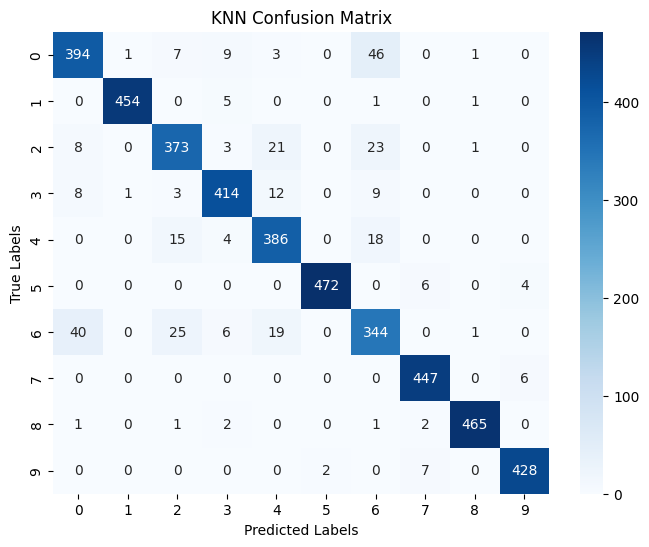

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       461
           1       1.00      0.98      0.99       461
           2       0.88      0.87      0.87       429
           3       0.93      0.93      0.93       447
           4       0.88      0.91      0.89       423
           5       1.00      0.98      0.99       482
           6       0.78      0.79      0.78       435
           7       0.97      0.99      0.98       453
           8       0.99      0.99      0.99       472
           9       0.98      0.98      0.98       437

    accuracy                           0.93      4500
   macro avg       0.93      0.93      0.93      4500
weighted avg       0.93      0.93      0.93      4500



In [59]:
# print Confusion Matrix for KNN with best parameters
knn_conf_matrix = confusion_matrix(y_val, knn_pred)

print("KNN Confusion Matrix:")
print(knn_conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# print classification_report 
knn_classification_report = classification_report(y_val, knn_pred)

print("KNN Classification Report:")
print(knn_classification_report)

Naive Bayes Confusion Matrix:
[[403   0   5  12   4   0  35   0   2   0]
 [  2 447   2   7   2   0   0   0   1   0]
 [  9   0 371   4  23   0  19   0   3   0]
 [  6   0   3 416  10   0  11   0   1   0]
 [  0   0  15  10 379   0  18   0   1   0]
 [  0   0   0   0   0 474   0   5   0   3]
 [ 50   0  26   7  19   0 332   0   1   0]
 [  0   0   0   0   0   1   0 446   1   5]
 [  1   0   0   2   1   0   2   2 464   0]
 [  0   0   0   0   0   2   0   8   0 427]]


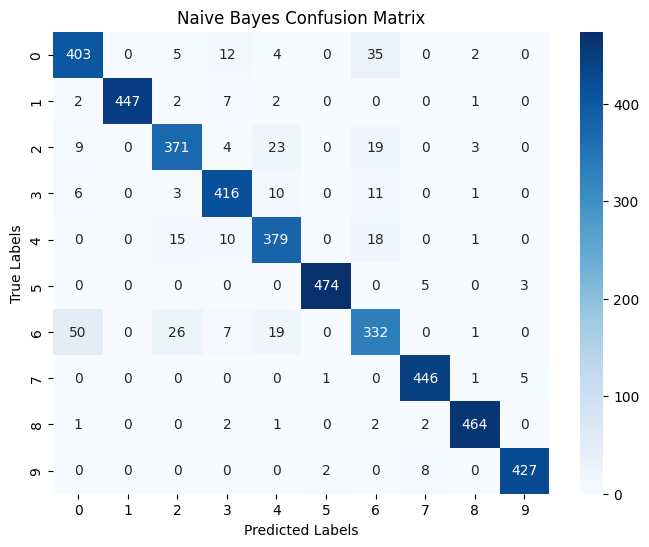

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       461
           1       1.00      0.97      0.98       461
           2       0.88      0.86      0.87       429
           3       0.91      0.93      0.92       447
           4       0.87      0.90      0.88       423
           5       0.99      0.98      0.99       482
           6       0.80      0.76      0.78       435
           7       0.97      0.98      0.98       453
           8       0.98      0.98      0.98       472
           9       0.98      0.98      0.98       437

    accuracy                           0.92      4500
   macro avg       0.92      0.92      0.92      4500
weighted avg       0.92      0.92      0.92      4500



In [60]:
# print Confusion Matrix for Naive Bayes with best parameters
bnb_conf_matrix = confusion_matrix(y_val, bnb_pred)

print("Naive Bayes Confusion Matrix:")
print(bnb_conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(bnb_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# print classification_report 
bnb_classification_report = classification_report(y_val, bnb_pred)

print("Naive Bayes Classification Report:")
print(bnb_classification_report)

SVM Confusion Matrix:
[[387   0   8  10   4   0  50   0   2   0]
 [  1 451   1   6   1   0   0   0   1   0]
 [ 13   0 370   2  19   0  24   0   1   0]
 [ 11   3   4 407  14   0   7   0   1   0]
 [  0   0  26  10 369   0  18   0   0   0]
 [  0   0   0   0   0 474   0   4   0   4]
 [ 43   0  28   5  19   0 337   0   3   0]
 [  0   0   0   0   0   0   0 445   2   6]
 [  2   0   0   1   0   0   1   2 466   0]
 [  0   0   0   0   0   2   0   8   0 427]]


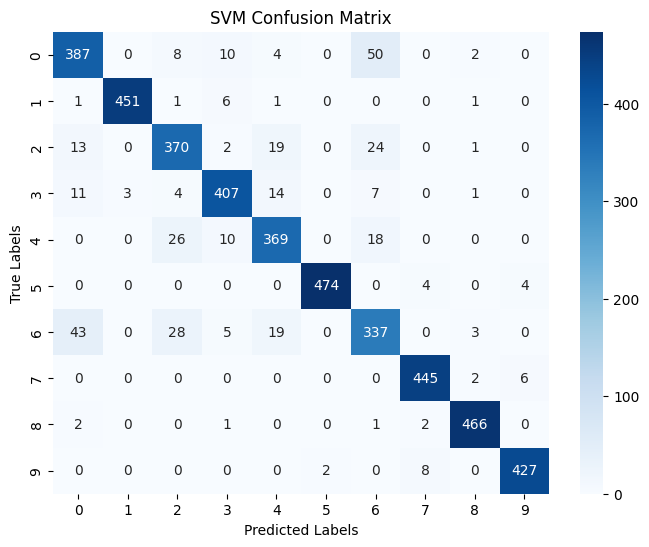

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       461
           1       0.99      0.98      0.99       461
           2       0.85      0.86      0.85       429
           3       0.92      0.91      0.92       447
           4       0.87      0.87      0.87       423
           5       1.00      0.98      0.99       482
           6       0.77      0.77      0.77       435
           7       0.97      0.98      0.98       453
           8       0.98      0.99      0.98       472
           9       0.98      0.98      0.98       437

    accuracy                           0.92      4500
   macro avg       0.92      0.92      0.92      4500
weighted avg       0.92      0.92      0.92      4500



In [62]:
# print Confusion Matrix for SVM with best parameters
svm_conf_matrix = confusion_matrix(y_val, svm_pred)

print("SVM Confusion Matrix:")
print(svm_conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# print classification_report 
svm_classification_report = classification_report(y_val, svm_pred)

print("SVM Classification Report:")
print(svm_classification_report)

Random Forest Confusion Matrix:
[[393   0   5   9   4   0  48   0   2   0]
 [  1 450   0   7   1   0   1   0   1   0]
 [  7   0 374   4  20   0  21   0   3   0]
 [  8   1   3 412  12   0  11   0   0   0]
 [  0   0  15   9 378   0  21   0   0   0]
 [  0   0   0   0   0 474   0   5   0   3]
 [ 41   0  25   7  18   0 343   0   1   0]
 [  0   0   0   0   0   1   0 446   1   5]
 [  1   0   0   2   1   0   2   2 463   1]
 [  0   0   0   0   0   2   0   5   0 430]]


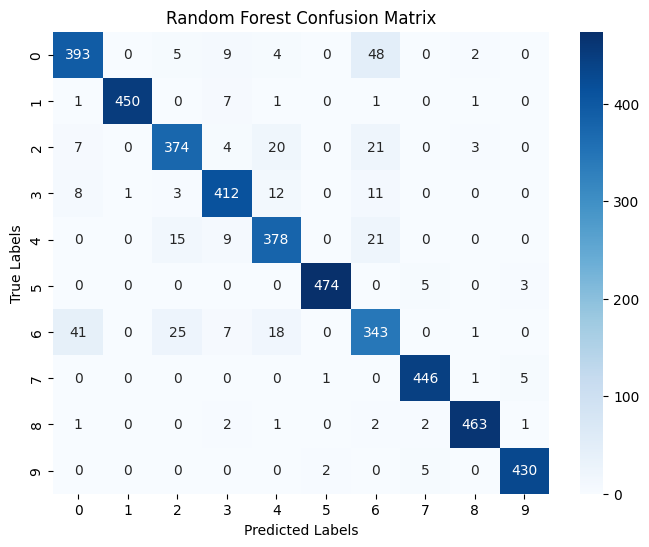

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       461
           1       1.00      0.98      0.99       461
           2       0.89      0.87      0.88       429
           3       0.92      0.92      0.92       447
           4       0.87      0.89      0.88       423
           5       0.99      0.98      0.99       482
           6       0.77      0.79      0.78       435
           7       0.97      0.98      0.98       453
           8       0.98      0.98      0.98       472
           9       0.98      0.98      0.98       437

    accuracy                           0.93      4500
   macro avg       0.92      0.92      0.92      4500
weighted avg       0.93      0.93      0.93      4500



In [63]:
# print Confusion Matrix for Random Forest with best parameters
rf_conf_matrix = confusion_matrix(y_val, rf_pred)

print("Random Forest Confusion Matrix:")
print(rf_conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# print classification_report 
rf_classification_report = classification_report(y_val, rf_pred)

print("Random Forest Classification Report:")
print(rf_classification_report)

# Comparison

Compare all classifiers with their optimized hyper-parameters, focusing on criteria such as classification performance, training time, and inference time. Visualization of these comparisons is required; use high-quality plots, figures, or tables to facilitate a clear understanding of the differences and strengths of each model.

In [64]:
# Create a dictionary to store all models and their predictions
models = {
    'KNN': (best_knn_model, knn_pred),
    'Naive Bayes': (best_gnb_model, gnb_pred),  # Using the best-performing Naive Bayes model
    'SVM': (best_svm_model, svm_pred),
    'Random Forest': (best_rf_model, rf_pred)
}

# Calculate performance metrics for each model
metrics = {
    'Accuracy': accuracy_score,
    'F1 Score': lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
    'Precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted'),
    'Recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted')
}

# Store the performance results for each model
results = {model: {metric: func(y_val, pred) for metric, func in metrics.items()} 
           for model, (_, pred) in models.items()}


Model Performance Comparison:
               Accuracy  F1 Score  Precision    Recall
KNN            0.928222  0.928356   0.928645  0.928222
Naive Bayes    0.922000  0.921855   0.921886  0.922000
SVM            0.918444  0.918548   0.918712  0.918444
Random Forest  0.925111  0.925324   0.925663  0.925111


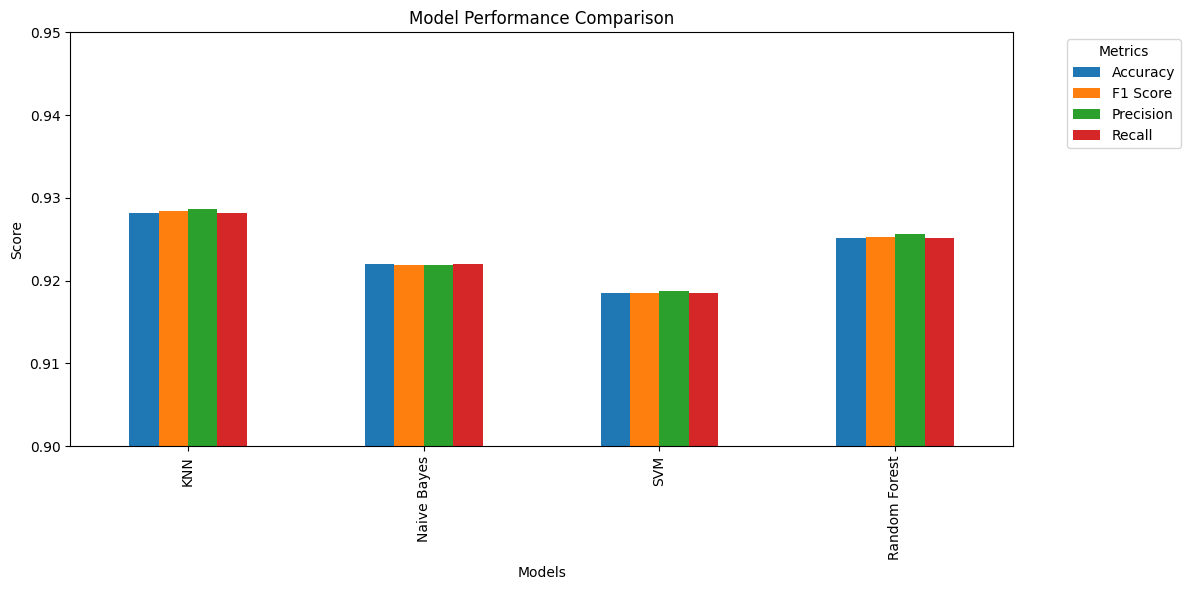


Best Model (based on Accuracy): KNN
Best Model Accuracy: 0.9282


In [65]:
# Create a comparison table
comparison_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(comparison_df)

# Visualize the comparison
plt.figure(figsize=(12, 6))
ax = plt.gca()
comparison_df.plot(kind='bar', ax=ax)
ax.set_ylim(0.9, 0.95)
plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Score')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Find the best-performing model (based on accuracy)
best_model_name = max(results, key=lambda x: results[x]['Accuracy'])
print(f"\nBest Model (based on Accuracy): {best_model_name}")
print(f"Best Model Accuracy: {results[best_model_name]['Accuracy']:.4f}")


# The Best Classifier

The best classifier is KNN using the best parameters.

# Loading testing data

Load the testing data for prediction

In [66]:
# test2.csv includes 5000 samples used for label prediction. Test samples do not have labels.
data_test_df = pd.read_csv('./data/test1.csv', index_col=0)
# print out the first 5 rows of the test dataframe
data_test_df.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v776,v777,v778,v779,v780,v781,v782,v783,v784,label
id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
3,0,0,0,0,0,0,0,0,0,40,...,0,0,0,0,0,0,0,0,0,3
4,0,0,1,0,2,0,0,0,0,58,...,155,143,69,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [67]:
# Get the actual best model object
best_model = models[best_model_name][0]
# Predict on test data
data_test_df = pd.read_csv('./data/test1.csv')
X_test = data_test_df.loc[:, "v1":"v784"].to_numpy()
X_test_scaled = X_test/255.0
X_test_reshaped = X_test_scaled.reshape(-1, 1, 28, 28)
X_test_tensor = torch.FloatTensor(X_test_reshaped)

with torch.no_grad():
    X_test_features = model.extract_features(X_test_tensor.to(device)).cpu().numpy()

predictions = best_model.predict(X_test_features)

# Save predictions
output_df = pd.DataFrame(predictions, columns=['label'])

output_df.to_csv('./test_output.csv', sep=",", float_format='%d', index_label="id")
print("Predictions saved to test_output.csv")

Predictions saved to test_output.csv


Save prediction vector as a `test_output.csv` file, which contains two columns: `id` and `label`. Please refer to the `example_output.csv` for the structure of this output file.